In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gensim.downloader as api
import seaborn as sns
from scipy.stats import ttest_rel
import os

In [2]:
try:
    from framework import WordleAnalyzer
except ImportError:
    print("Importing WordleAnalyzer from parent directory...")
    os.chdir("../")
    print(f"Changed dir to {os.getcwd()}")
    from framework import WordleAnalyzer
    print("Imported 'framework' module successfully.")


Importing WordleAnalyzer from parent directory...
Changed dir to c:\Users\adamk\Desktop\gerzhoy research\AI matters\wordle-research\data_analysis


c:\Users\adamk\miniconda3\envs\wordle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Loading models...
Imported 'framework' module successfully.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adamk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adamk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: for multilingual WordNet data
nltk.download('punkt')     # Optional: for tokenization

from nltk.corpus import wordnet as wn

# Function to get the synsets of the word
def get_synsets(word):
    return wn.synsets(word)

def calc_path_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            sim = synset1.path_similarity(synset2)
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def calc_wup_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            sim = synset1.wup_similarity(synset2)
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def calc_lch_similarity(word1, word2):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    
    # Ensure words have synsets (not all words exist in WordNet)
    if not synsets1 or not synsets2:
        return -1000
    
    # Initialize maximum similarity
    max_sim = -1000
    
    # Iterate through all synset pairs and calculate the similarity
    for synset1 in synsets1:
        for synset2 in synsets2:
            try:
                sim = synset1.lch_similarity(synset2)
            except:
                sim = None
            
            # Update maximum similarity found
            if sim is not None and sim > max_sim:
                max_sim = sim
    
    return max_sim

def get_pairwise_similarity(data, sim_function):
    human_similarity, optimal_similarity = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_similarity[state] = []
        optimal_similarity[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i][-1].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            try:
                opt_sim = sim_function(prev, opt)
                hum_sim = sim_function(prev, hum)
                if opt_sim == -1000 or hum_sim == -1000:
                    skipped += 1
                    continue
            except:
                # print(glove_distance(prev, opt, model))
                skipped += 1
                continue
            

            optimal_similarity[state].append(opt_sim)
            human_similarity[state].append(hum_sim)

        # print(f"Skipped {skipped} words for {state}")


    return human_similarity, optimal_similarity

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adamk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adamk\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adamk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [5]:
# Load the pre-trained GloVe model (300 dimensions, trained on Wikipedia + Gigaword)
glove_model = api.load('glove-wiki-gigaword-300')
w2v_model = api.load('word2vec-google-news-300')

# Function to calculate cosine similarity between two vectors

# Function to compute distance between two words using GloVe
def glove_distance(word1, word2, model):
    if word1 in model and word2 in model:
        vec1 = model[word1]
        vec2 = model[word2]
        
        # Calculate Cosine Similarity
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity  # Cosine distance
        
        return similarity, distance
    else:
        return f"One or both words ('{word1}', '{word2}') not found in the GloVe model."

def word2vec_distance(word1, word2, model):
    if word1 in model and word2 in model:
        vec1 = model[word1]
        vec2 = model[word2]
        
        # Calculate Cosine Similarity
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity  # Cosine distance
        
        return similarity, distance
    else:
        return f"One or both words ('{word1}', '{word2}') not found in the Word2Vec model."


In [6]:
minimax = pd.read_csv('data/state_data_minimax.csv')
entropy = pd.read_csv('data/state_data.csv')

In [7]:
def get_pairwise_distance(data, sim_function, model):
    human_distance, optimal_distance = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_distance[state] = []
        optimal_distance[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i][-1].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            try:
                opt_sim, opt_dist = sim_function(prev, opt, model)
                hum_sim, hum_dist = sim_function(prev, hum, model)
            except:
                # print(glove_distance(prev, opt, model))
                skipped += 1
                continue
            

            optimal_distance[state].append(opt_dist)
            human_distance[state].append(hum_dist)

        # print(f"Skipped {skipped} words for {state}")


    return human_distance, optimal_distance


In [8]:
def get_statistics_with_previous(data, sim_function):
    human_similarity, optimal_similarity = {}, {}

    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        state = row['state']
        previous_guesses = eval(row['previous_guesses'])
        optimal_guesses = eval(row['optimal_guess'])
        human_guesses = eval(row['human_guess'])

        human_similarity[state] = []
        optimal_similarity[state] = []
        skipped = 0
        
        for i in range(len(previous_guesses)):
            prev = previous_guesses[i].lower()
            opt = optimal_guesses[i].lower()
            hum = human_guesses[i].lower()
            hum_avg = 0
            opt_avg = 0
            for p in prev:
                hum_avg += sim_function(p, hum)
                opt_avg += sim_function(p, opt)
            opt_avg /= len(prev)
            hum_avg /= len(prev)
                    
            

            optimal_similarity[state].append(opt_avg)
            human_similarity[state].append(hum_avg)

        # print(f"Skipped {skipped} words for {state}")


    return human_similarity, optimal_similarity

In [9]:
glove_distance('dad', 'mom', w2v_model)

(0.7470093, 0.25299072265625)

In [ ]:
# print(analyze.levenshtein_between_guesses('apple', 'tester'))
# print(analyze.common_syllables('apple', 'tester'))
# print(analyze.shared_chars('apple', 'tester'))
# WordleAnalyzer.levenshtein_between_guesses

In [10]:


human_similarity, optimal_similarity = get_pairwise_similarity(entropy, WordleAnalyzer.shared_chars)
file_path = 'new_shared_chars/entropy/shared_chars'

100%|██████████| 19/19 [00:02<00:00,  7.62it/s]


In [11]:
print(len((human_similarity[14])))

26050


In [12]:
# compute cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [13]:
def prettify_state(state):
    written_state = [0] * 3
    written_state[0] = state//100
    written_state[1] = (state%100)//10
    written_state[2] = state%10
    return f'{written_state[0]}g{written_state[1]}y{written_state[2]}b'


In [14]:
print((human_similarity[14]))

[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

In [15]:
def get_statistics(human_distance, optimal_distance, title):
    # make a new pandas dataframe, with the column names state, cohen distance, t statistic, p value, number of samples
    stats_data = pd.DataFrame(columns=['state', 'Cohen Distance', 't_statistic', 'p_value', 'num_samples', 'human_mean', 'human_std', 'optimal_mean', 'optimal_std'])


    for state in human_distance.keys():
        cohen_dist = cohen_d(human_distance[state], optimal_distance[state])
        statistic, p_value = ttest_rel(human_distance[state], optimal_distance[state])
        number = len(human_distance[state])
        human_mean = np.mean(human_distance[state])
        human_std = np.std(human_distance[state])
        optimal_mean = np.mean(optimal_distance[state])
        optimal_std = np.std(optimal_distance[state])
        stats_data = stats_data.append({'state': prettify_state(state), 'Cohen Distance': cohen_dist, 't_statistic': statistic, 'p_value': p_value, 'num_samples': number, 'human_mean': human_mean, 'human_std': human_std, 'optimal_mean': optimal_mean, 'optimal_std': optimal_std}, ignore_index=True)

    stats_data.to_csv(f'{title}_statistics.csv', index=False)
    plt.figure()
    sns.histplot(stats_data['Cohen Distance'])

    plt.savefig(f'{title}_cohen_distance.pdf', format='pdf')
    return stats_data


    # make a new pandas dataframe


In [16]:
get_statistics(human_similarity, optimal_similarity, file_path)

AttributeError: 'DataFrame' object has no attribute 'append'

In [17]:
print(len(human_similarity[14]))

26050


In [18]:
min = 1
max = 0
for state, value in human_similarity.items():
    for v in value:
        if v < min:
            min = v
        if v > max:
            max = v

for state, value in optimal_similarity.items():
    for v in value:
        if v < min:
            min = v
        if v > max:
            max = v

print(min, max)
print(human_similarity.keys())

0 5
dict_keys([14, 23, 32, 302, 5, 104, 203, 113, 401, 311, 212, 122, 41, 221, 131, 320, 140, 230, 50])


In [19]:
def graph_histograms(state, human_distance, optimal_distance, title, x_axis, type, discrete=False):
    plt.figure()
    sns.set_palette("bright")
    data = pd.DataFrame({x_axis: human_distance[state] + optimal_distance[state], type: ['Human']*len(human_distance[state]) + ['Optimal']*len(optimal_distance[state])})
    sns.histplot(data=data, x=x_axis, hue=type, discrete=discrete, multiple='layer', shrink=0.8)
    plt.text(0.5, 1, f"Cohen's distance: {cohen_d(human_distance[state], optimal_distance[state]):.{3}g}, p-value: {ttest_rel(human_distance[state], optimal_distance[state]).pvalue:.{3}g}", horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=10)

    plt.savefig(f'{title}_histogram_{prettify_state(state)}.pdf', format='pdf')
    print(f'Cohens d {cohen_d(human_distance[state], optimal_distance[state])}')

<Axes: >

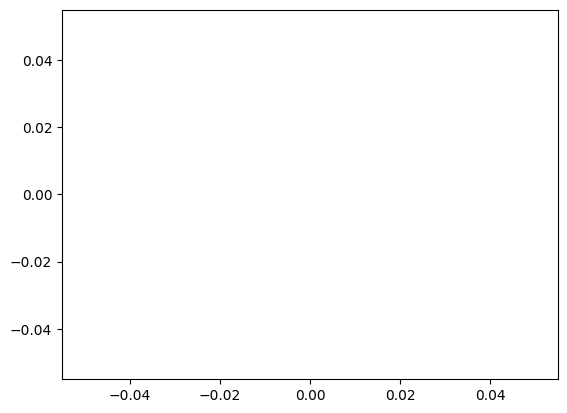

In [20]:
sns.histplot()

In [21]:
for state in human_similarity.keys():
    graph_histograms(state, human_similarity, optimal_similarity, file_path, "Distance", "Type", discrete=True, mult = 'dodge')

TypeError: graph_histograms() got an unexpected keyword argument 'mult'

In [22]:
graph_histograms(221)

TypeError: graph_histograms() missing 5 required positional arguments: 'human_distance', 'optimal_distance', 'title', 'x_axis', and 'type'

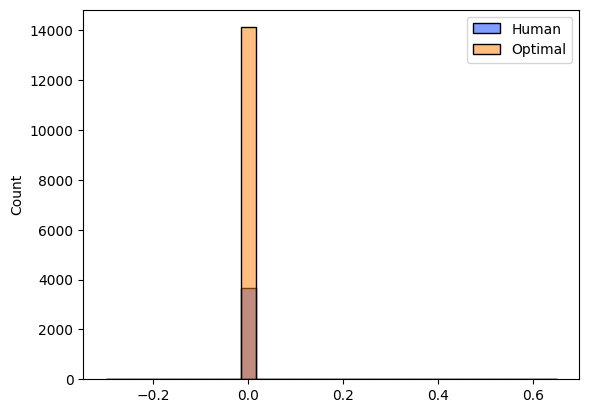

In [23]:
import seaborn as sns
# I want to generate histograms of optimal_similary[14] and human_similarity[14] in one coll
# sns.histplot(human_similarity[14], bins=30, alpha=0.5, label='Human')
# sns.histplot(optimal_similarity[14], bins=30, alpha=0.5, label='Optimal')

# I want a histogram that is normalized to 0 to 1
# subsample 5000 random indices from the human_similarity[14] and optimal_similarity[14]
idx = np.random.choice(len(human_similarity[14]), len(human_similarity[14]), replace=False)
human_similarity_subsample = [human_similarity[14][i] for i in idx]
optimal_similarity_subsample = [optimal_similarity[14][i] for i in idx]
# sns.histplot(human_similarity_subsample, bins=(), alpha=0.5, label='Human', stat = 'count')
# sns.histplot(optimal_similarity_subsample, bins=30, alpha=0.5, label='Optimal', stat = 'count', color = None)

# the range is from -0.3 to 0.65, want 30 evenly spaced bins for both histograms
sns.histplot(human_similarity[14], binrange=[-0.3, 0.65], bins=30, alpha=0.5, label='Human', stat = 'count')
sns.histplot(optimal_similarity[14], binrange=[-0.3, 0.65], bins=30, alpha=0.5, label='Optimal', stat = 'count', color = None)

# only include first and third label in legend
plt.legend()

